In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_dataset_dir = 'MangoCare_Dataset'  # Update this if necessary
base_dir = 'MangoCare_Split'  # Directory to save splits
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories for train, validation, and test datasets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split each class into train, val, and test sets
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        files = os.listdir(class_path)
        train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

        # Move files
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("Dataset successfully split into Train, Validation, and Test sets.")


Dataset successfully split into Train, Validation, and Test sets.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only normalization for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    'MangoCare_Split/train',  # Update path if necessary
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'MangoCare_Split/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'MangoCare_Split/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)
print(f"Train Samples: {train_generator.samples}")
print(f"Validation Samples: {val_generator.samples}")
print(f"Classes: {train_generator.class_indices}")



Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Samples: 3200
Validation Samples: 400
Classes: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
# from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Input(shape=(150, 150, 3)),  # Explicitly define the input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.2512 - loss: 2.8063 - val_accuracy: 0.6150 - val_loss: 1.1404
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 326ms/step - accuracy: 0.5962 - loss: 1.1334 - val_accuracy: 0.6875 - val_loss: 0.7645
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 325ms/step - accuracy: 0.7404 - loss: 0.7154 - val_accuracy: 0.8775 - val_loss: 0.4214
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.7999 - loss: 0.5577 - val_accuracy: 0.8900 - val_loss: 0.3236
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.8436 - loss: 0.4357 - v

In [19]:
 pip install matplotlib


   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.8 MB 4.8 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.8 MB 3.9 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.8 MB 3.6 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.8 MB 3.7 MB/s eta 0:00:02
   -------------------- ------------------- 3.9/7.8 MB 3.7 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 3.4 MB/s eta 0:00:01
   ---------------------------- ----------- 5.5/7.8 MB 3.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.3/7.8 MB 3.7 MB/s eta 0:00:01
   ---------------------------------- ----- 6.8/7.8 MB 3.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.1/7.8 MB 3.4 MB/s eta 0:00:01
   -------------------------------------- - 7.6/7.8 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 3.2 MB/s eta 0:00:00
   ---------------

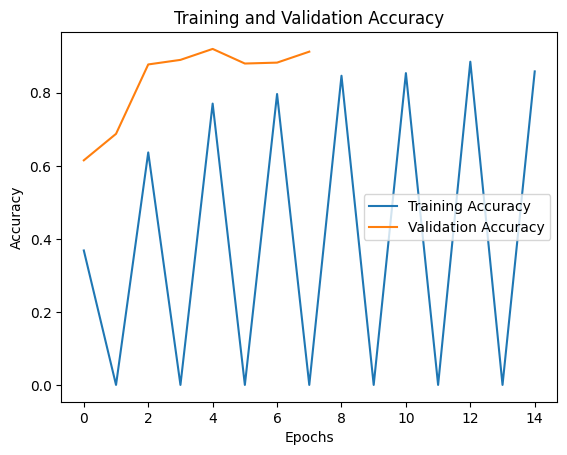

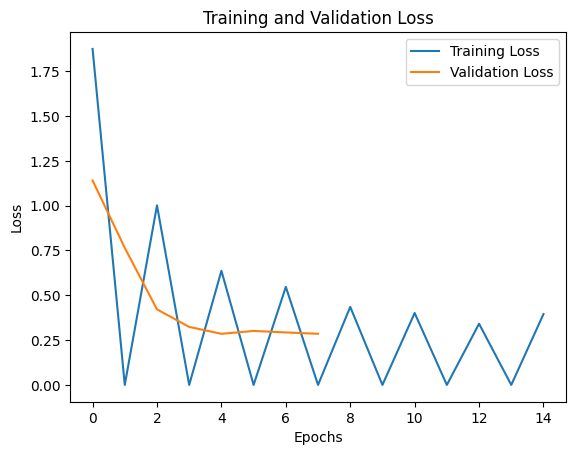

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model.save("MangoCare.h5")

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = load_model("MangoCare.h5")


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    'MangoCare_Split/test', 
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)


test_loss, test_accuracy = model.evaluate(test_generator)


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 400 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9326 - loss: 0.2314 
Test Accuracy: 89.75%
Test Loss: 0.3070


Found 400 images belonging to 8 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


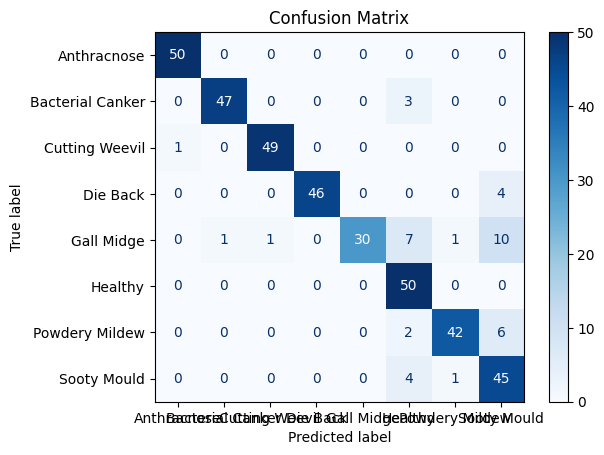

                  precision    recall  f1-score   support

     Anthracnose       0.98      1.00      0.99        50
Bacterial Canker       0.98      0.94      0.96        50
  Cutting Weevil       0.98      0.98      0.98        50
        Die Back       1.00      0.92      0.96        50
      Gall Midge       1.00      0.60      0.75        50
         Healthy       0.76      1.00      0.86        50
  Powdery Mildew       0.95      0.84      0.89        50
     Sooty Mould       0.69      0.90      0.78        50

        accuracy                           0.90       400
       macro avg       0.92      0.90      0.90       400
    weighted avg       0.92      0.90      0.90       400



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


model = load_model("MangoCare.h5")


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'MangoCare_Split/test', 
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 


cm = confusion_matrix(true_classes, predicted_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


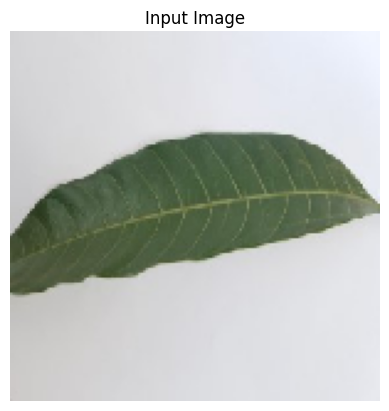

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Class Probabilities:
Anthracnose: 0.00%
Bacterial Canker: 0.00%
Cutting Weevil: 0.00%
Die Back: 0.00%
Gall Midge: 0.00%
Healthy: 96.72%
Powdery Mildew: 0.18%
Sooty Mould: 3.10%

Predicted Class: Healthy
Confidence: 96.72%


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("MangoCare.h5")

# Path to the image to predict
image_path = 'MangoCare_Split/test/Healthy/20211231_123310 (Custom).jpg'  

# Preprocess the image
img = image.load_img(image_path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')
plt.show()

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  

# Make predictions
predictions = model.predict(img_array)[0] 

# Get class labels from the model
class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 
                'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']  

# Display predictions for all classes
print("\nClass Probabilities:")
for i, label in enumerate(class_labels):
    print(f"{label}: {predictions[i] * 100:.2f}%")

# Find the class with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[predicted_class_index] * 100  

# Output the top prediction
print(f"\nPredicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


In [1]:
model.save("MangoCare.h5")

NameError: name 'model' is not defined